In [1]:
ls

encoder.json    p2_evaluate.py    sample_data/  vocab.bpe
get_dataset.sh  requirements.txt  tokenizer.py


In [ ]:
!pip3 install -r requirements.txt
# Oracle Java
!sudo add-apt-repository ppa:webupd8team/java
!sudo apt upadte
!apt-get install oracle-java8-installer

# libxml-parser-perl
!sudo apt install libxml-parser-perl
!pip install git+https://github.com/bckim92/language-evaluation.git
!python -c "import language_evaluation; language_evaluation.download('coco')"

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
!pip install --upgrade gdown
!gdown 11rP6KmR5Qwjhx0rfag0b5TZGBTRuPtQR -O hw3_data.zip

In [ ]:
!unzip ./hw3_data.zip

In [55]:
import torch
import timm
import torchvision.transforms as transforms
from PIL import Image
from torch import nn
from tokenizer import BPETokenizer
#from decoder import Decoder, Config
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import resize
import json
import os
import torch.nn.functional as F
import loralib as lora
import sys
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as tud

PEFT_train_type = 'adapter'
encoder_json_path = './encoder.json'
vocab_file_path = './vocab.bpe'
decoder_checkpoint = './hw3_data/p2_data/decoder_model.bin'

In [6]:
import math
import collections
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import loralib as lora

class Config:

    def __init__(self, checkpoint=None, peft_type ="adapter", atten_map_flag=False, cross_n_embd=384):
        self.n_layer = 12
        self.n_head = 12
        self.n_embd = 768
        self.vocab_size = 50257
        self.block_size = 1024
        self.checkpoint = checkpoint
        self.adapter_size = int(self.n_embd * 0.5)
        self.peft_type = peft_type
        self.dropout = 0.1
        self.atten_map_flag = atten_map_flag
        self.cross_n_embd = cross_n_embd

class Attention(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        if cfg.peft_type == "lora":
            self.c_attn = lora.Linear(cfg.n_embd, 3 * cfg.n_embd, r=8)
            self.c_proj = lora.Linear(cfg.n_embd, cfg.n_embd, r=8)
        else:
            self.c_attn = nn.Linear(cfg.n_embd, 3 * cfg.n_embd)
            self.c_proj = nn.Linear(cfg.n_embd, cfg.n_embd)
        self.n_head = cfg.n_head
        self.n_embd = cfg.n_embd
        size = cfg.block_size
        self.register_buffer('bias', torch.tril(torch.ones(size, size)).view(1, 1, size, size))

    def forward(self, x):
        B, T, C = x.size() # batch, context, embedding
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        return self.c_proj((att @ v).transpose(1, 2).contiguous().view(B, T, C))

class CrossAttention(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.query = nn.Linear(cfg.n_embd, cfg.cross_n_embd) # how about 384, 192
        self.key = nn.Linear(1024, cfg.cross_n_embd)
        self.value = nn.Linear(1024, cfg.cross_n_embd)
        self.c_proj_cross = nn.Linear(cfg.cross_n_embd, cfg.n_embd)
        self.n_head = cfg.n_head
        self.n_embd = cfg.cross_n_embd
        size = cfg.block_size
        self.register_buffer('bias', torch.tril(torch.ones(size, size)).view(1, 1, size, size))

    def forward(self, x_text, x_image):
        B, T_text, C_text = x_text.size()  # batch, context_text, embedding_text
        _, T_image, C_image = x_image.size()  # batch, context_image, embedding_image

        q_text = self.query(x_text)
        q_text = q_text.view(B, T_text, self.n_head, self.n_embd // self.n_head).transpose(1, 2)

        # Maybe change C_text to C_images?
        k_image = self.key(x_image)
        v_image = self.value(x_image)
        k_image = k_image.view(B, T_image, self.n_head, self.n_embd // self.n_head).transpose(1, 2)
        v_image = v_image.view(B, T_image, self.n_head, self.n_embd // self.n_head).transpose(1, 2)
        att = (q_text @ k_image.transpose(-2, -1)) * (1.0 / math.sqrt(k_image.size(-1)))
        # att = att.masked_fill(self.bias[:, :, :T_text, :T_text] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)

        return self.c_proj_cross((att @ v_image).transpose(1, 2).contiguous().view(B, T_text, self.n_embd)), att

class AdapterLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(AdapterLayer, self).__init__()
        self.downsample = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        self.upsample = nn.Linear(output_size, input_size)

    def forward(self, x):
        downsampled = self.downsample(x)
        activated = self.relu(downsampled)
        upsampled = self.upsample(activated)
        return x + upsampled

class Block(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.ln_1 = nn.LayerNorm(cfg.n_embd)
        self.ln_2 = nn.LayerNorm(cfg.n_embd)
        self.ln_3 = nn.LayerNorm(cfg.n_embd)
        self.dropout_1 = nn.Dropout(cfg.dropout)
        self.dropout_2 = nn.Dropout(cfg.dropout)
        self.dropout_3 = nn.Dropout(cfg.dropout)
        if cfg.peft_type == "adapter":
            self.adapter_layer_1 = AdapterLayer(cfg.n_embd, cfg.adapter_size)
            #self.adapter_layer_2 = AdapterLayer(cfg.n_embd, cfg.adapter_size)
            self.adapter_layer_3 = AdapterLayer(cfg.n_embd, cfg.adapter_size)
        self.attn = Attention(cfg)
        self.attn_cross = CrossAttention(cfg)  # cross-attention between text and image
        self.mlp = nn.Sequential(collections.OrderedDict([
            ('c_fc', nn.Linear(cfg.n_embd, 4 * cfg.n_embd)),
            ('act', nn.GELU(approximate='tanh')),
            ('c_proj', nn.Linear(4 * cfg.n_embd, cfg.n_embd))
        ]))

    def forward(self, x, x_image):
        # x = x + self.attn(self.ln_1(x))
        # x = x + self.attn_cross(self.ln_2(x), x_image)
        # x = x + self.mlp(self.ln_3(x))
        if self.cfg.peft_type == "adapter":
            x = x + self.adapter_layer_1(self.dropout_1(self.attn(self.ln_1(x))))
            x_cross, atten_map = self.attn_cross(self.ln_2(x), x_image)
            x = x + self.dropout_2(x_cross)
            x = x + self.adapter_layer_3(self.dropout_3(self.mlp(self.ln_3(x))))
        elif self.cfg.peft_type == "lora":
            x = x + self.dropout_1(self.attn(self.ln_1(x)))
            x_cross, atten_map = self.attn_cross(self.ln_2(x), x_image)
            x = x + self.dropout_2(x_cross)
            x = x + self.dropout_3(self.mlp(self.ln_3(x)))
        else:
            x = x + self.dropout_1(self.attn(self.ln_1(x)))
            x_cross, atten_map = self.attn_cross(self.ln_2(x), x_image)
            x = x + self.dropout_2(x_cross)
            x = x + self.dropout_3(self.mlp(self.ln_3(x)))
        return x, atten_map

class Decoder(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.block_size = cfg.block_size
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(cfg.vocab_size, cfg.n_embd),
            wpe = nn.Embedding(cfg.block_size, cfg.n_embd),
            h = nn.ModuleList([Block(cfg) for _ in range(cfg.n_layer)]),
            ln_f = nn.LayerNorm(cfg.n_embd)
        ))
        self.lm_head = nn.Linear(cfg.n_embd, cfg.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight

        # load checkpoint
        if self.cfg.checkpoint is not None:
            state_dict = torch.load(self.cfg.checkpoint)
            transposed = [ '.c_attn.weight', '.c_fc.weight', '.c_proj.weight' ]
            for key, value in state_dict.items():
                if any(key.endswith(w) for w in transposed):
                    state_dict[key] = value.t()
            self.transformer.load_state_dict(state_dict, strict=False)

    def forward(self, x, x_image):
        x = torch.narrow(x, 1, 0, min(x.size(1), self.block_size))
        pos = torch.arange(x.size()[1], dtype=torch.long, device=x.device).unsqueeze(0)
        x = self.transformer.wte(x) + self.transformer.wpe(pos)

        atten_map_all = []
        for block in self.transformer.h:
            x, atten_map = block(x, x_image)
            atten_map_all.append(atten_map)
        # [layer_num, batch_size, head_num, max_len, encode_size**2]
        atten_map_all = torch.stack(atten_map_all)
        atten_map_all = torch.mean(atten_map_all, dim=2)

        x = self.lm_head(self.transformer.ln_f(x))
        if self.cfg.atten_map_flag:
            return x, atten_map_all
        else:
            return x

class PrefixEncoder(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.prefix_projection = config.prefix_projection
        token_dim = config.token_dim
        num_layers = config.num_layers
        encoder_hidden_size = config.encoder_hidden_size
        num_virtual_tokens = config.num_virtual_tokens
        if self.prefix_projection and not config.inference_mode:
            # Use a two-layer MLP to encode the prefix
            self.embedding = torch.nn.Embedding(num_virtual_tokens, token_dim)
            self.transform = torch.nn.Sequential(
                torch.nn.Linear(token_dim, encoder_hidden_size),
                torch.nn.Tanh(),
                torch.nn.Linear(encoder_hidden_size, num_layers * 2 * token_dim),
            )
        else:
            self.embedding = torch.nn.Embedding(num_virtual_tokens, num_layers * 2 * token_dim)

    def forward(self, prefix: torch.Tensor):
        if self.prefix_projection:
            prefix_tokens = self.embedding(prefix)
            past_key_values = self.transform(prefix_tokens)
        else:
            past_key_values = self.embedding(prefix)
        return past_key_values

class DecoderPrefixTuning(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        # self.prefix_config = [
        #     peft_type="PREFIX_TUNING",
        #     task_type="SEQ_2_SEQ_LM",
        #     num_virtual_tokens=20,
        #     token_dim=768,
        #     num_transformer_submodules=1,
        #     num_attention_heads=12,
        #     num_layers=12,
        #     encoder_hidden_size=768,
        #     prefix_projection=True,
        #     inference_mode=False,
        # ]
        self.cfg = cfg
        self.block_size = cfg.block_size
        self.prefix_encoder = PrefixEncoder(prefix_config)  # Add PrefixEncoder
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(cfg.vocab_size, cfg.n_embd),
            wpe = nn.Embedding(cfg.block_size, cfg.n_embd),
            h = nn.ModuleList([Adapter(cfg) for _ in range(cfg.n_layer)]),
            ln_f = nn.LayerNorm(cfg.n_embd)
        ))
        self.lm_head = nn.Linear(cfg.n_embd, cfg.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight

        if self.cfg.checkpoint is not None:
            state_dict = torch.load(self.cfg.checkpoint)
            transposed = [ '.c_attn.weight', '.c_fc.weight', '.c_proj.weight' ]
            for key, value in state_dict.items():
                #print(key)
                if any(key.endswith(w) for w in transposed):
                    #print(key)
                    state_dict[key] = value.t()
            self.transformer.load_state_dict(state_dict, strict=False)

    def forward(self, x, x_image):
        x = torch.narrow(x, 1, 0, min(x.size(1), self.block_size))
        pos = torch.arange(x.size()[1], dtype=torch.long, device=x.device).unsqueeze(0)
        x = self.transformer.wte(x) + self.transformer.wpe(pos)

        # Add PrefixEncoder to encode the prefix
        prefix = torch.randint(0, 20, (x.size(0), 20))
        prefix_embedding = self.prefix_encoder(prefix)
        x = x + prefix_embedding

        for block in self.transformer.h:
            x = block(x, x_image)
        x = self.lm_head(self.transformer.ln_f(x))
        return x

In [7]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.images = sorted(os.listdir(image_folder))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        # Read image file
        image_path = os.path.join(self.image_folder, self.images[idx])
        image = Image.open(image_path).convert("RGB")
        key = os.path.splitext(self.images[idx])[0]
        if self.transform:
            image = self.transform(image)
        return image, key

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as needed
    transforms.ToTensor(),
])

# Create an instance of the BPETokenizer
tokenizer = BPETokenizer(encoder_file=encoder_json_path, vocab_file=vocab_file_path)

class EncoderDecoder(nn.Module):
    def __init__(self, decoder_checkpoint=None, peft_type="adapter"):
        super(EncoderDecoder, self).__init__()
        #model_name = 'vit_base_patch16_clip_224.laion2b_ft_in12k_in1k'
        #model_name = 'vit_large_patch14_clip_224.openai_ft_in12k_in1k'
        model_name = 'vit_large_patch14_clip_224.openai'
        self.encoder = timm.create_model(model_name, pretrained=True, num_classes=0)
        for param in self.encoder.parameters():
            param.requires_grad = False
        for submodule in self.encoder.children():
            for param in submodule.parameters():
                param.requires_grad = False

        self.peft_type = peft_type
        if self.peft_type == "adapter":
            cross_n_embd = 384
        elif self.peft_type == "lora":
            cross_n_embd = 768
        self.decoder_cfg = Config(checkpoint=decoder_checkpoint, peft_type=peft_type, cross_n_embd=cross_n_embd, atten_map_flag=True)
        self.decoder = Decoder(cfg=self.decoder_cfg)
        for param in self.decoder.parameters():
            param.requires_grad = False

    def forward(self, images, captions):
        # Forward propagation
        features = self.encoder.forward_features(images)
        outputs = self.decoder(captions, features)
        return outputs

## Visualization of Attention in five test images

In [8]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
val_image_folder = 'hw3_data/p3_data/images/'
val_dataset = CustomDataset(val_image_folder, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=1)

checkpoint_name = 'adapter_none_4.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EncoderDecoder(decoder_checkpoint=decoder_checkpoint, peft_type=PEFT_train_type).to(device)
model.eval()

checkpoint_path = os.path.join('./drive/MyDrive/Colab_Notebooks/hw3_model_checkpoint', checkpoint_name)
state_dict = torch.load(checkpoint_path)
model.load_state_dict(state_dict, strict=False)

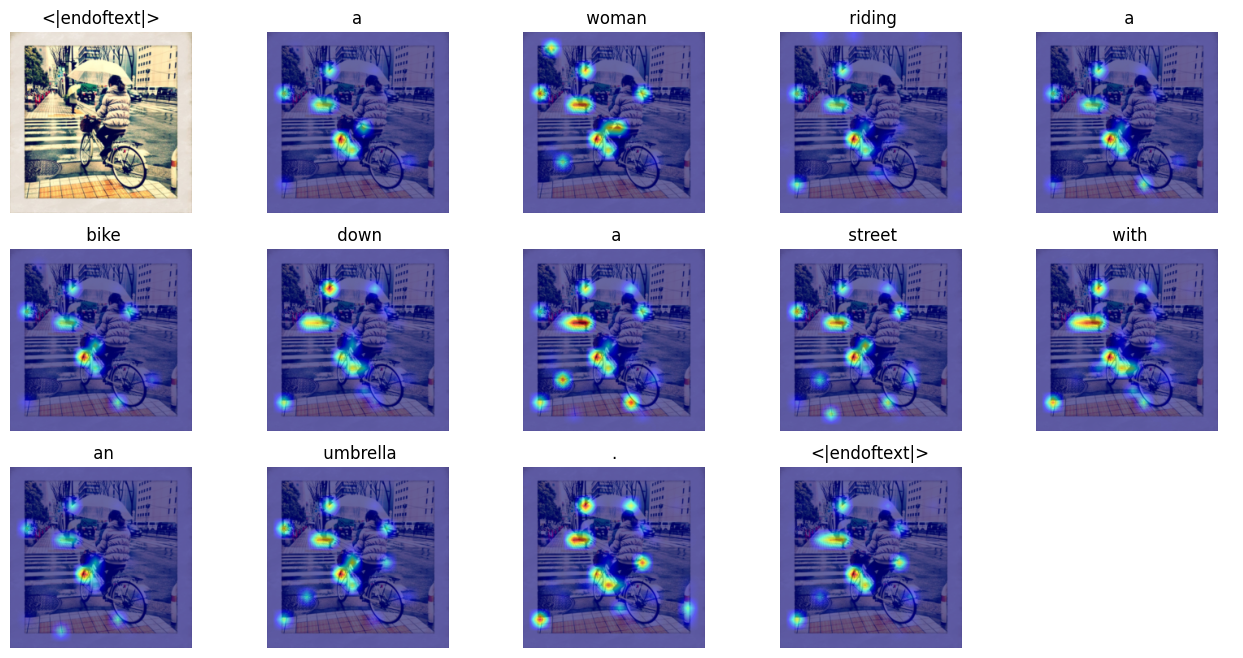

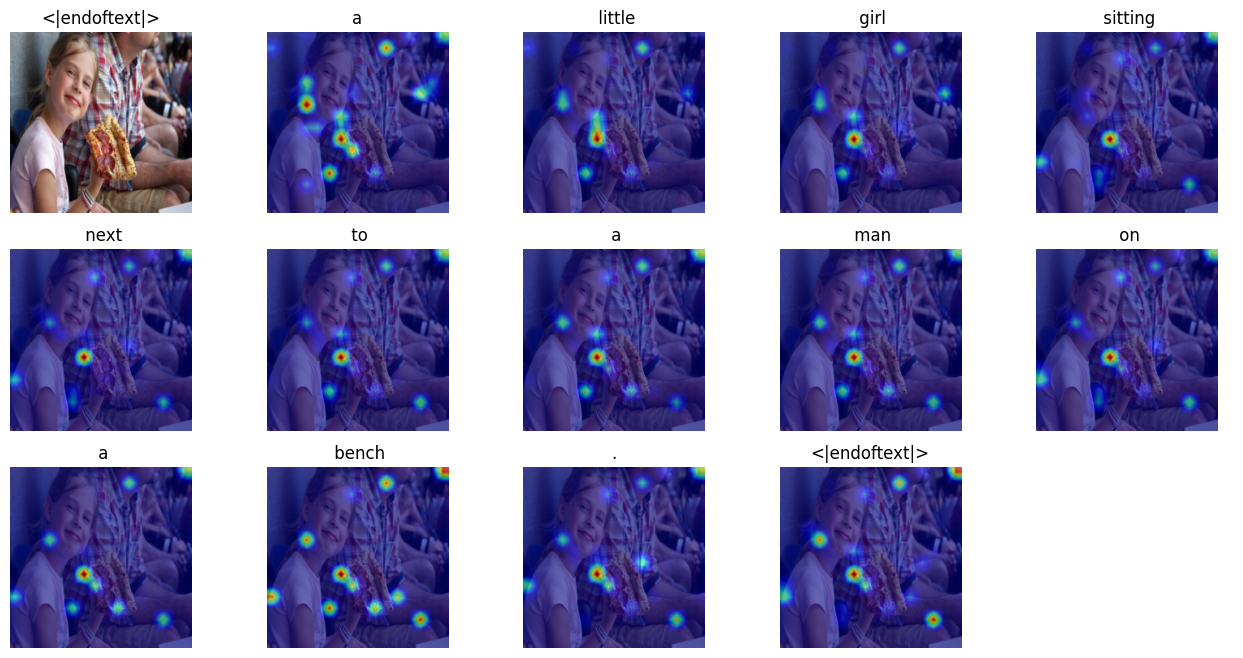

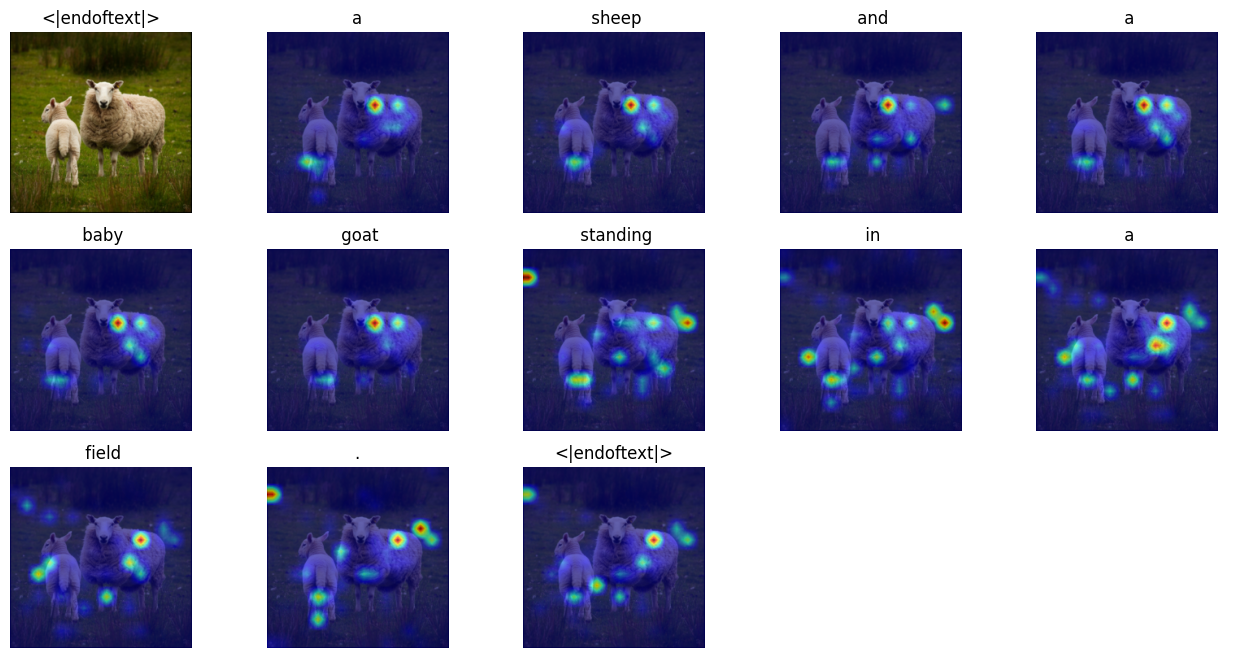

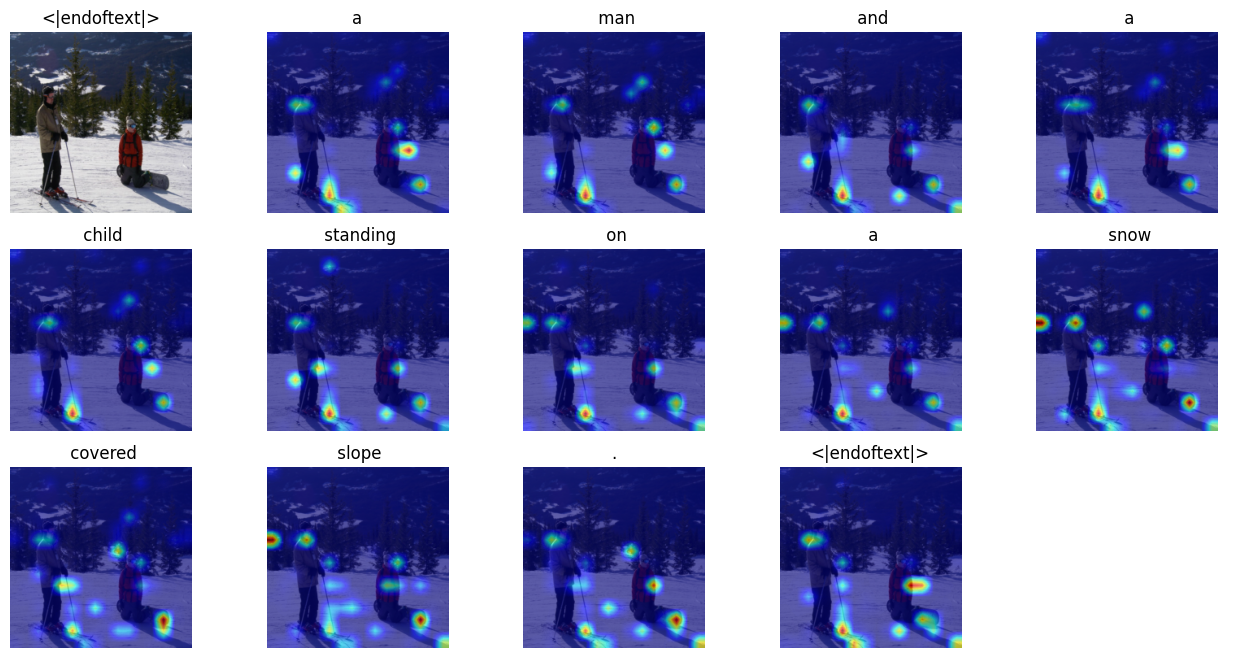

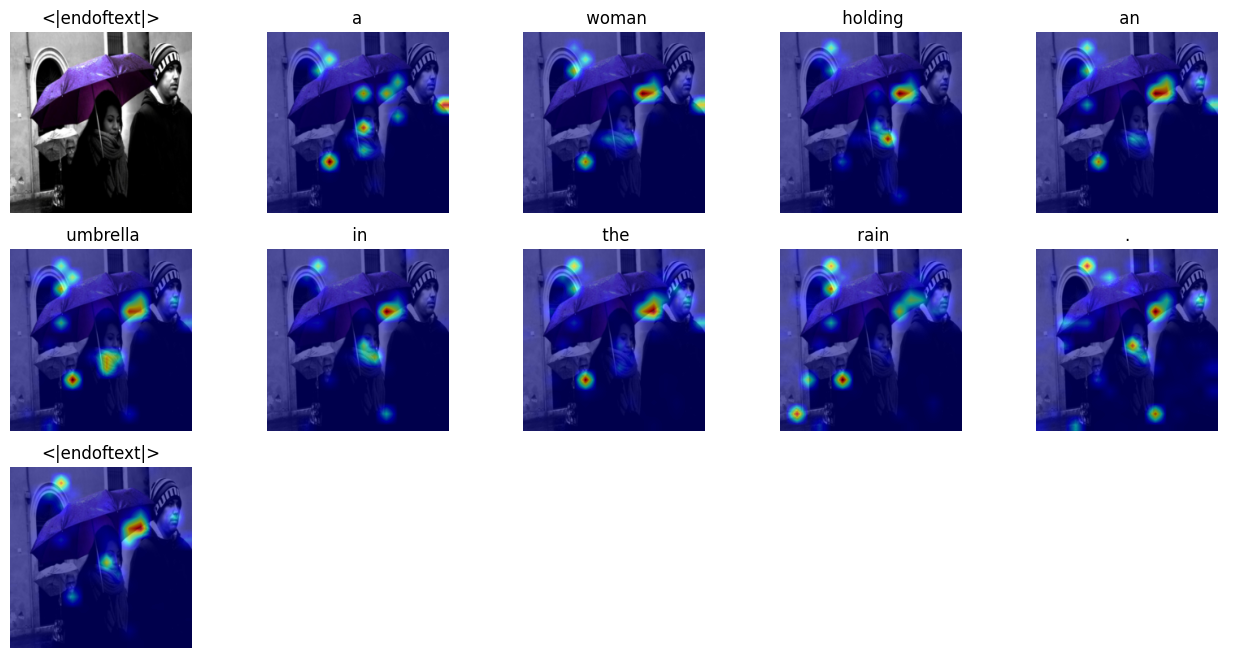

In [73]:
predictions = {}
with torch.no_grad():
    for images, images_id in val_dataloader:
        images, images_id = images.to(device), images_id
        start_token = tokenizer.encode('<|endoftext|>', allowed_special=['<|endoftext|>'])[0]
        caption_input = torch.tensor([[start_token]] * 64).transpose(1, 0) .to(device)
        max_caption_length = 30
        fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(16, 8))
        ax[0][0].imshow(images.squeeze(0).permute(1, 2, 0).cpu().numpy())
        ax[0][0].set_title('<|endoftext|>')
        for i in range(3):
            for j in range(5):
                ax[i][j].axis('off')
        max_len = 30
        features = model.encoder.forward_features(images)
        for i in range(max_len-1):
            predictions, atten_map = model.decoder(caption_input, features)
            predictions = predictions[:, i, :]
            next_char = torch.argmax(predictions, axis=-1)

            atten_map = atten_map.squeeze(1)[-1].cpu()
            #print(atten_map.shape)
            atten_map_head = atten_map[i, 1:]
            #print(atten_map_head.shape)
            atten_map_head = torch.reshape(atten_map_head, (16, 16))
            #atten_map_head =  (atten_map_head - atten_map_head.min()) / (atten_map_head.max() - atten_map_head.min())
            atten_map_head =  (atten_map_head - torch.min(atten_map_head)) / (torch.max(atten_map_head) - torch.min(atten_map_head))
            #print(atten_map_head.shape)
            atten_map_head = resize(atten_map_head.unsqueeze(0), [224,224]).squeeze(0)
            #atten_map_head = F.interpolate(atten_map_head.view(1, 1, 16, 16), (224, 224), mode='bilinear').view(224, 224, 1)
            ax[(i+1) // 5][(i+1) % 5].imshow(np.transpose(images.cpu()[0].numpy(), (1, 2, 0)))
            ax[(i+1) // 5][(i+1) % 5].imshow(atten_map_head, alpha=0.6, cmap='jet')
            ax[(i+1) // 5][(i+1) % 5].set_title(tokenizer.decode(next_char.cpu().tolist()))
            if next_char[0] == 50256:
                break
            caption_input[:, i+1] = next_char
        predicted_captions = [tokenizer.decode(tokens.tolist()[1:]) for tokens in caption_input[:,:i+1]]

## Visualization of Attention in Top-1 and last-1 image-caption pairs with CLIPScore

In [75]:
from p2_evaluate import CLIPScore
from tqdm import tqdm
val_image_folder = 'hw3_data/p2_data/images/val'
val_dataset = CustomDataset(val_image_folder, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=1)

In [69]:
all_output = {}
best_clip_score = 0
worst_clip_score = 1
calCLIP = CLIPScore()
with torch.no_grad():
    for images, images_id in tqdm(val_dataloader):
        output = {}
        images = images.to(device)
        start_token = tokenizer.encode('<|endoftext|>', allowed_special=['<|endoftext|>'])[0]
        caption_input = torch.tensor([[start_token]] * 64).transpose(1, 0).to(device)
        max_len = 30
        features = model.encoder.forward_features(images)
        for i in range(max_len-1):
            predictions, atten_map = model.decoder(caption_input, features)
            predictions = predictions[:, i, :]
            next_char = torch.argmax(predictions, axis=-1)

            if next_char[0] == 50256:
                break
            caption_input[:, i+1] = next_char
        predicted_captions = [tokenizer.decode(tokens.tolist()[1:]) for tokens in caption_input[:,:i+1]]
        #print(predicted_captions[0])
        for img_id, pred_caption in zip(images_id, predicted_captions):
            output[str(img_id)] = pred_caption
            all_output[str(img_id)] = pred_caption
        clip_score = calCLIP(output, val_image_folder)
        if clip_score > best_clip_score:
            best_clip_score = clip_score
            best_image_id = str(images_id[0])
        if clip_score < worst_clip_score:
            worst_clip_score = clip_score
            worst_image_id = str(images_id[0])
    print(' ')
    print(f'Best image id: {best_image_id}, Clip score: {best_clip_score}')
    print(f'Worst image id: {worst_image_id}, Clip score: {worst_clip_score}')

100%|██████████| 1789/1789 [10:46<00:00,  2.77it/s]

 
Best image id: 000000340181, Clip score: 1.0076904296875
Worst image id: 000000028523, Clip score: 0.3265380859375


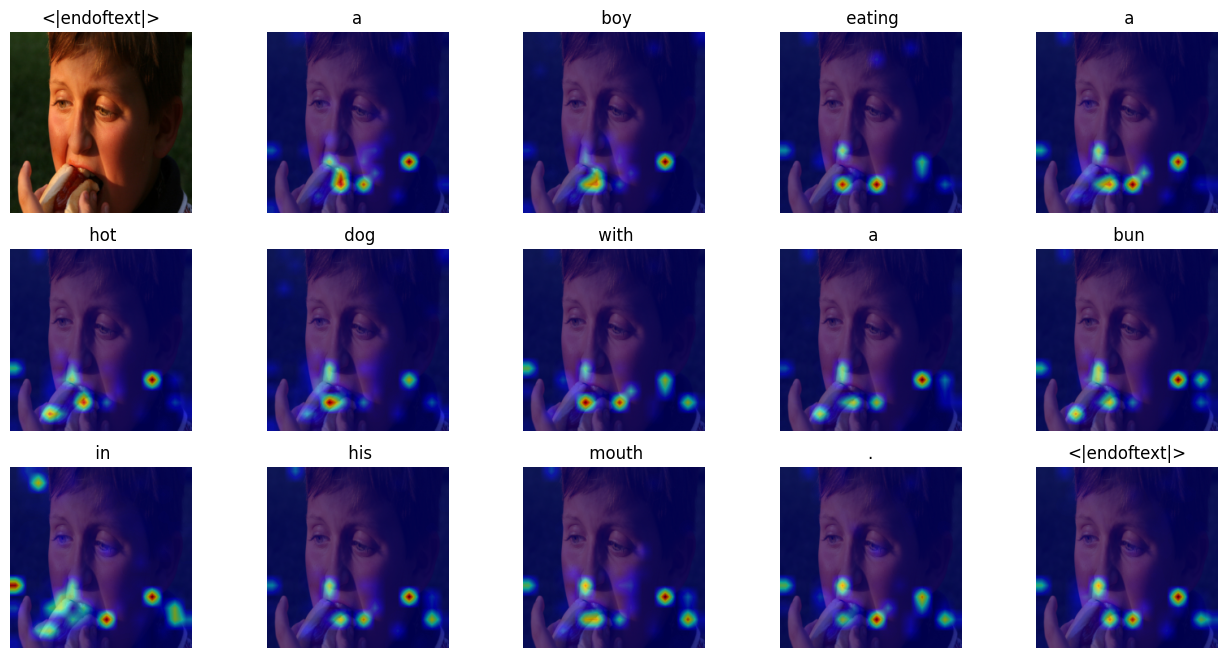

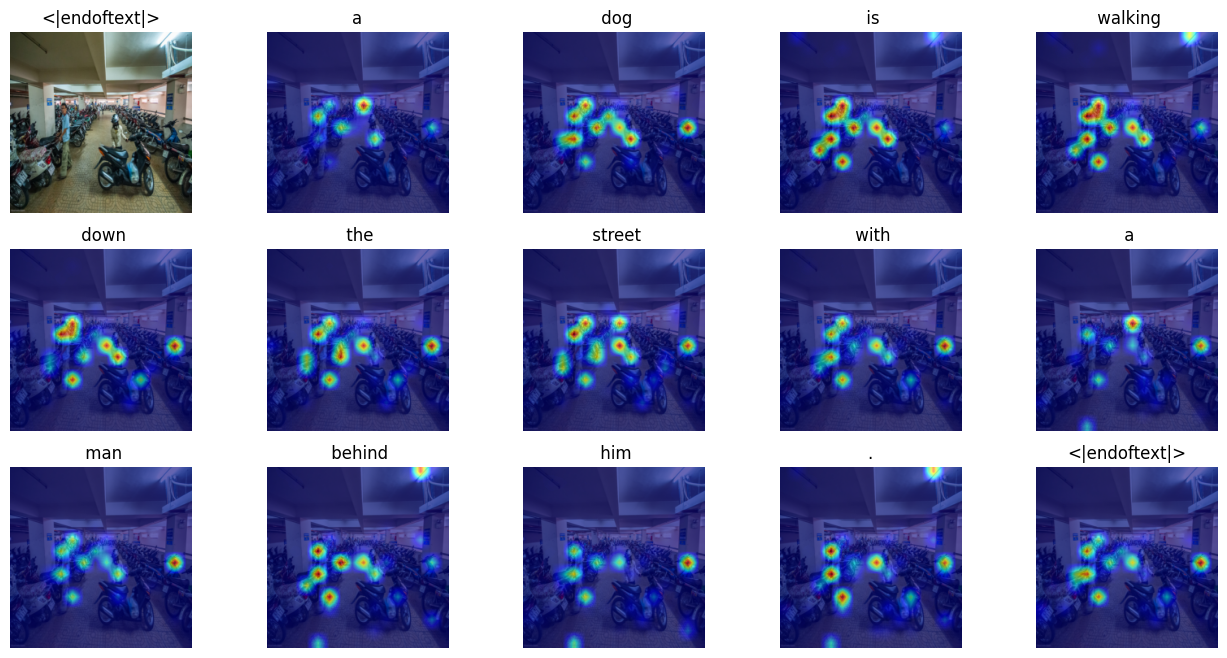

In [76]:
filenames = [best_image_id, worst_image_id]

with torch.no_grad():
    for filename in filenames:
        image_path = os.path.join(val_image_folder, f'{filename}.jpg')
        image = Image.open(image_path).convert("RGB")
        image = val_transform(image)
        image = image.unsqueeze(0)
        images = image.to(device)
        start_token = tokenizer.encode('<|endoftext|>', allowed_special=['<|endoftext|>'])[0]
        caption_input = torch.tensor([[start_token]] * 64).transpose(1, 0).to(device)

        fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(16, 8))
        ax[0][0].imshow(images.squeeze(0).permute(1, 2, 0).cpu().numpy())
        ax[0][0].set_title('<|endoftext|>')
        for i in range(3):
            for j in range(5):
                ax[i][j].axis('off')
        max_len = 30
        features = model.encoder.forward_features(images)
        for i in range(max_len-1):
            predictions, atten_map = model.decoder(caption_input, features)
            predictions = predictions[:, i, :]
            next_char = torch.argmax(predictions, axis=-1)

            atten_map = atten_map.squeeze(1)[-1].cpu()
            atten_map_head = atten_map[i, 1:]
            atten_map_head = torch.reshape(atten_map_head, (16, 16))
            atten_map_head =  (atten_map_head - atten_map_head.min()) / (atten_map_head.max() - atten_map_head.min())
            atten_map_head = resize(atten_map_head.unsqueeze(0), [224,224]).squeeze(0)

            ax[(i+1) // 5][(i+1) % 5].imshow(np.transpose(images.cpu()[0].numpy(), (1, 2, 0)))
            ax[(i+1) // 5][(i+1) % 5].imshow(atten_map_head, alpha=0.6, cmap='jet')
            ax[(i+1) // 5][(i+1) % 5].set_title(tokenizer.decode(next_char.cpu().tolist()))
            if next_char[0] == 50256:
                break
            caption_input[:, i+1] = next_char